#Transfer Learning and TeonsorFlow Hub

[TensorFlow Hub](https://www.tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use. These models can either be used as is, or they can be used for Transfer Learning.

Transfer Learning is the process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get adifferent set of possible outputs. Here in [TensorFlow Module Hub](https://tfhub.dev) are all available models.

Concepts covered:
1. Use a TensorFlow Hub model for prediction.
2. Use a TensorFlow Hub model for Cats vs. Dogs dataset.
3. Do simple transfer learning with TensorFlow Hub.

#Imports

The new import is tensorflow_hub. We will make great use of tensorflow_hub.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#Use TensorFlow Hub MobileNet for predition

In this part we'll take a trained model, load it into keras and try it out. The model we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?module-type=image-classification&q=tf2) would work.

##Download the classifier

Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 244 by 244, in 3 colour channels (RGB).

In [ ]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
                             hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

##Run it on a single image

MobileNet has been trained on the ImageNet dataset, having 1000 different output classes, and one of them is military uniforms. Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is military uniform.

65536/61306 [================================] - 0s 0us/step


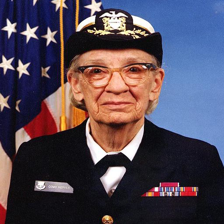

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass hte image to the model for prediction.

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image. So the top class ID can be found with argmax, but how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

##Decode the predictions
To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

16384/10484 [==============================================] - 0s 0us/step


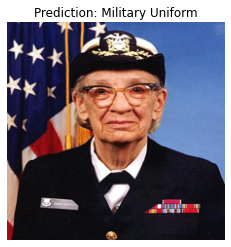

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction: ' + predicted_class_name.title())

#Use a TensorFlow Hub models for the Cats vs. Dogs dataset

We'll use the full MobileNet model and see how it can perform on the Cats vs. Dogs dataset.

##Dataset
We can use TensorFlow datasets to laod the Cats vs. Dogs dataset.

In [ ]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]']
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteXY6Z15/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The images in the Cats vs. Dogs dataset are not all the same size.

In [ ]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (244, 244). The `repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the suffle-buffer only has to cold-start once.

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES,IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

##Run the classifier on a batch of images
Remember our model object is still hte full MobileNet model trained on ImageNet, so it has 1000 possible output classes. ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Cats vs. Dogs dataset.

In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Brittany spaniel', 'grey fox', 'Egyptian cat',
       'Labrador retriever', 'golden retriever', 'tabby', 'Egyptian cat',
       'tabby', 'tiger cat', 'Chihuahua', 'Labrador retriever',
       'golden retriever', 'tabby', 'toy terrier', 'Egyptian cat',
       'tabby', 'tabby', 'tiger cat', 'stove', 'golden retriever',
       'crossword puzzle', 'Egyptian cat', 'keeshond',
       'flat-coated retriever', 'toy terrier', 'whippet', 'Shih-Tzu',
       'toy terrier', 'kelpie', 'Siamese cat', 'boxer', 'Egyptian cat'],
      dtype='<U30')

The labels seem to match names of Cats and Dogs. Let's plot the images from our Cats vs Dogs dataset and put the ImageNet labels next to them.

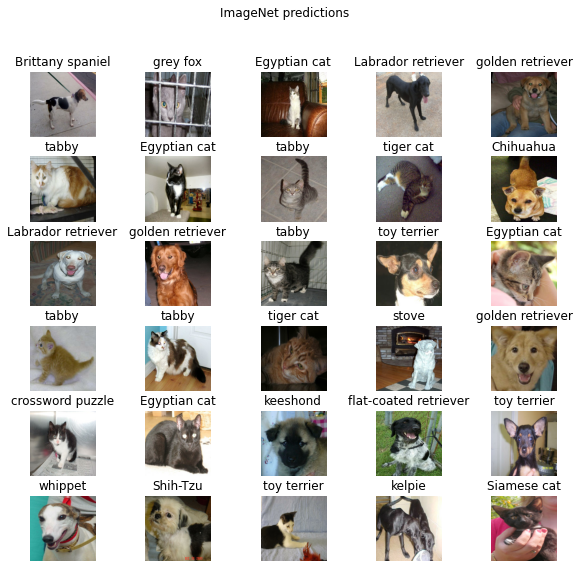

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

#Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer, which can be used easily to do transfer learning. We will continue using MobileNet v2. Any [image featre vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3)
                                   )

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in hte feature extractor layer, so that the training only modifies the final classifier layer.

In [ ]:
feature_extractor.trainable = False

##Attach a classification head
Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [ ]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2, activation=tf.keras.activations.softmax)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


##Train the model
Now we train this model like any other, by first calling `compile` followed by `fit`.

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches
                    )

Epoch 1/6
582/582 [==============================] - 37s 53ms/step - loss: 0.0918 - accuracy: 0.9661 - val_loss: 0.0332 - val_accuracy: 0.9880
Epoch 2/6
582/582 [==============================] - 34s 52ms/step - loss: 0.0301 - accuracy: 0.9893 - val_loss: 0.0352 - val_accuracy: 0.9880
Epoch 3/6
582/582 [==============================] - 34s 52ms/step - loss: 0.0255 - accuracy: 0.9915 - val_loss: 0.0315 - val_accuracy: 0.9897
Epoch 4/6
582/582 [==============================] - 34s 52ms/step - loss: 0.0211 - accuracy: 0.9927 - val_loss: 0.0313 - val_accuracy: 0.9910
Epoch 5/6
582/582 [==============================] - 34s 52ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.0445 - val_accuracy: 0.9847
Epoch 6/6
582/582 [==============================] - 34s 52ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.0339 - val_accuracy: 0.9901


We get around 99% validation accuracy, which is absolutely awesome. Although not equivalent to TensorFlow Hub, you can check out how to create MobileNet in Keras [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py).

Let's plot the training and validation accuracy/loss graphs.

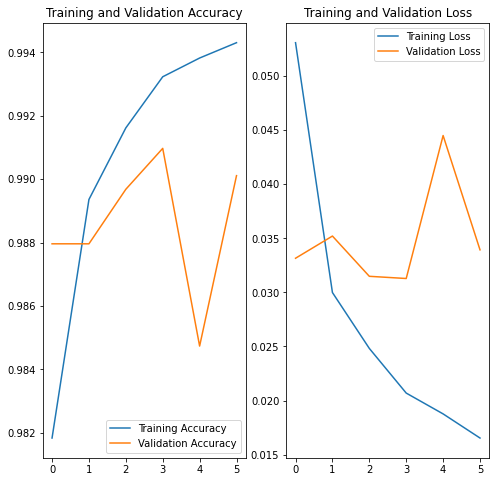

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Check Predictions
To redo the plot from before, first get the ordered list of class names.

In [ ]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat',
       'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog',
       'cat', 'dog', 'cat', 'dog', 'cat'], dtype='<U3')

In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0]
Predicted labels:  [1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0]


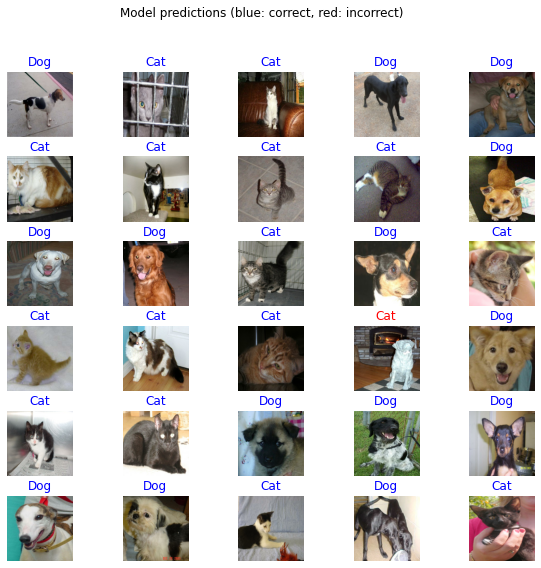

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")